In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import codecs

In [2]:
with codecs.open("../input/bbc_dataset.csv", "r", "Shift-JIS", "ignore") as file:
    df = pd.read_csv(file, delimiter=",")
df['category_id'] = df.type.factorize()[0]
df = shuffle(df)
df.head()

,news,type,category_id
1676,Thompson says Gerrard should stay\n \n Liverpo...,sport,3
1520,Player burn-out worries Robinson\n \n England ...,sport,3
337,DaimlerChrysler's 2004 sales rise\n \n US-Germ...,business,0
685,No jail for singer Courtney Love\n \n Singer C...,entertainment,1
1372,Wenger shock at Newcastle dip\n \n Arsenal man...,sport,3


In [3]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(
        df[:1500], df[:1500]["category_id"], num_epochs=None, shuffle=True)

predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
        df[1500:], df[1500:]["category_id"], shuffle=False)

In [4]:
embedded_text_feature_column = hub.text_embedding_column(
        key="news", 
        module_spec="https://tfhub.dev/google/Wiki-words-500/1")

INFO:tensorflow:Using /var/folders/k9/0d1smgqj6f9_hkzf80qfbw80941m76/T/tfhub_modules to cache modules.


In [5]:
estimator = tf.estimator.DNNClassifier(
        hidden_units=[500, 100],
        feature_columns=[embedded_text_feature_column],
        n_classes=5,
        optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k9/0d1smgqj6f9_hkzf80qfbw80941m76/T/tmpf_chcn8l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10740eb38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
estimator.train(input_fn=train_input_fn, steps=1000)

test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/k9/0d1smgqj6f9_hkzf80qfbw80941m76/T/tmpf_chcn8l/model.ckpt.
INFO:tensorflow:loss = 220.64456, step = 1
INFO:tensorflow:global_step/sec: 38.9326
INFO:tensorfl

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/k9/0d1smgqj6f9_hkzf80qfbw80941m76/T/tmpf_chcn8l/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


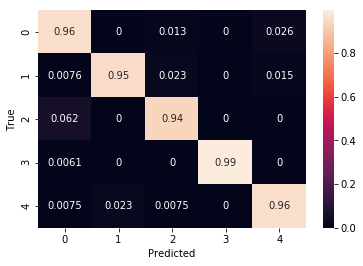

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    0, 1, 2, 3, 4
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(df[1500:]["category_id"], 
                           get_predictions(estimator, predict_test_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");